In [1]:
import os
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import phate
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir('../../src/')
import data_loader
import mappings
import scprep

In [2]:
PROJECT_PATH = '/home/mila/s/shuang.ni/phate_genetics/shuang/'
SCRATCH_PATH = '/home/mila/s/shuang.ni/scratch/phate_genetics/'
DATA_PATH = SCRATCH_PATH + '1KGP/V3/'
SAVE_PATH = SCRATCH_PATH + 'results/'
Figure_PATH = PROJECT_PATH + 'figures/'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'

# load data

In [3]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(DATA_PATH, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [ ]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

In [3]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs = load_from_local('../data/1000G/1000G_PCA')
pca_input = inputs.to_numpy()
labels = load_from_local('../data/1000G/1000G_labels')
admix_ratios = load_from_local('../data/1000G/1000G_admix_ratios')

# define confusion_matrix maker

In [4]:
def make_confusion_matrix(clusters, ax, colorbar=True):
    df = pd.DataFrame(columns=['PHATE Cluster', 'Population'])
    df['PHATE Cluster'] = clusters
    df['Population'] = labels['population'].to_numpy()

    # Filter out the -1 cluster (unclustered data)
    df = df[df['PHATE Cluster'] != -1]
    # Create a cross-tabulation of clusters and populations
    crosstab = pd.crosstab(df['PHATE Cluster'], df['Population'])
    # Convert counts to proportions
    proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

    # Reorder the populations to match the clusters
    ordered_populations = proportions.idxmax().sort_values().index
    proportions = proportions[ordered_populations]


    heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                            cbar=colorbar if colorbar else None, cbar_kws={'shrink': 0.8} if colorbar else None, ax=ax)
    heatmap.invert_yaxis()
    ax.set_xlabel('Population')
    ax.set_ylabel('PHATE Clusters')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=14)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)

    # Adjust the color bar tick labels font size
    if colorbar:
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)
    return heatmap

# PHATE 2D

In [5]:
# initial phate embedding
phate_operator_2d = phate.PHATE(random_state=42, 
                                n_components=2, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_2d.fit(pca_input)
phate_emb_2d = phate_operator_2d.transform()

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.65 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.70 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.24 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.89 seconds.
Calculated landmark operator in 2.95 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.16 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.46 seconds.


In [6]:
# phate clustering
clusters_2d = phate.cluster.kmeans(phate_operator_2d, n_clusters=24, max_clusters=28, random_state=42, k=None)
silhouette_score_2d = phate.cluster.silhouette_score(phate_operator_2d, n_clusters=24, random_state=42)
print(silhouette_score_2d)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7771290919226913


<Axes: title={'center': 'PHATE kmeans clusters\n (silhouette_score=0.772)'}, xlabel='PHATE 1', ylabel='PHATE 2'>

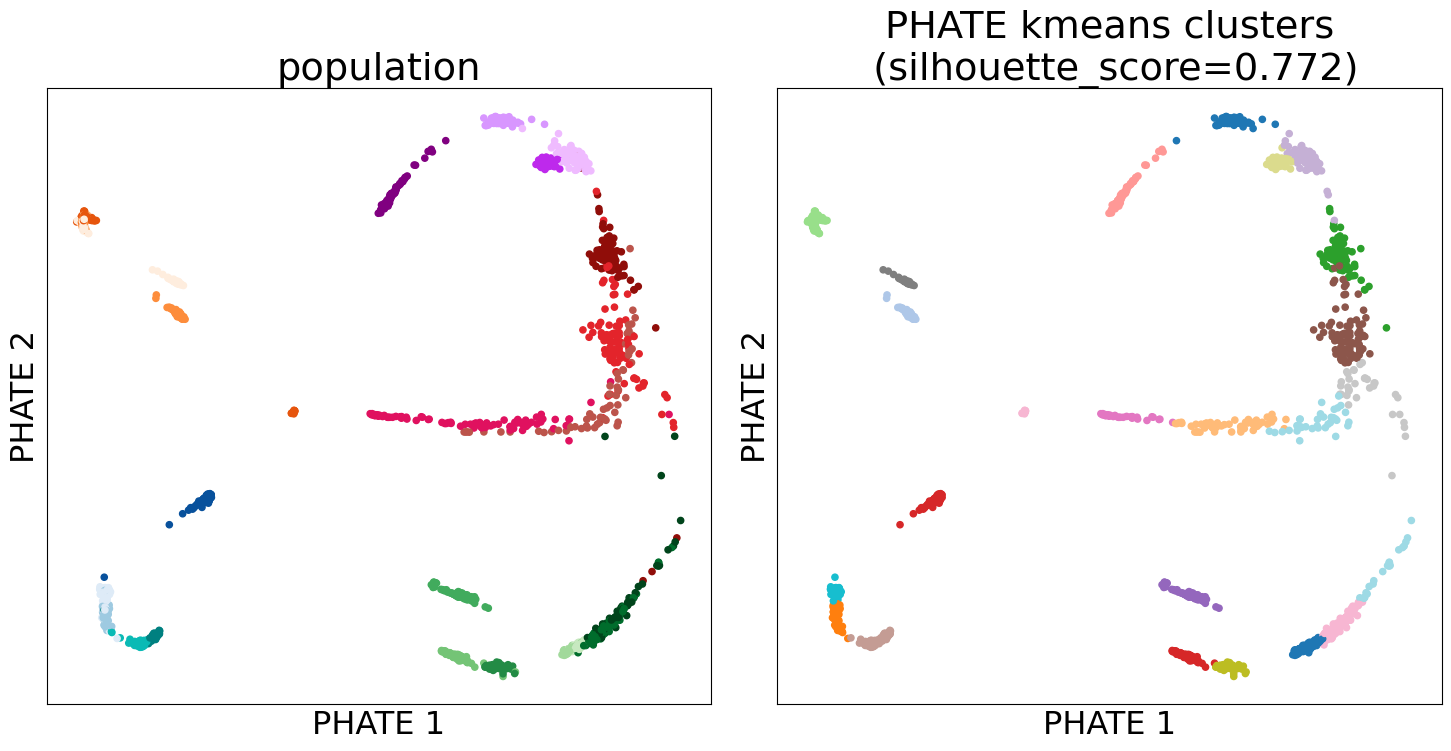

In [42]:
fig, axes = plt.subplots(1,2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap=mappings.pop_pallette_1000G_fine, c=labels['population'],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title='population', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20,ax=axes[1],
                      c=clusters_2d, cmap='tab20', 
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title=f'PHATE kmeans clusters\n (silhouette_score={silhouette_score:.3f})', fontsize=16)

In [7]:
ARI_2d = adjusted_rand_score(labels['population'], clusters_2d)
ARI_2d

0.6868032213641133

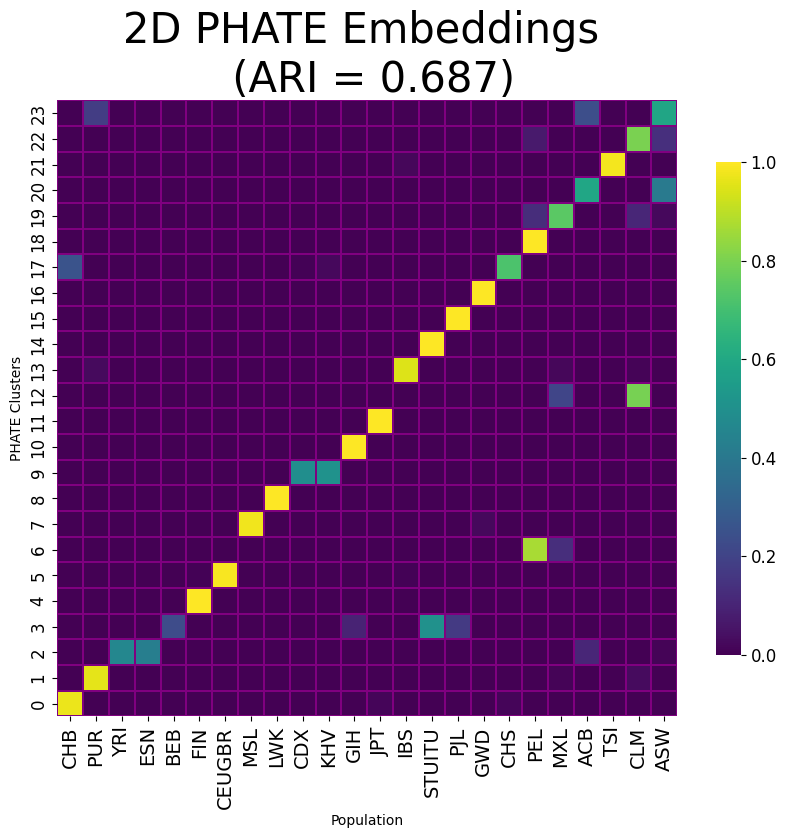

In [9]:
fig, axes = plt.subplots(1,1, figsize=(10, 8))
make_confusion_matrix(clusters_2d, ax=axes, colorbar=True)
_ = axes.set_title(f'2D PHATE Embeddings \n (ARI = {ARI_2d:.3f})', size=30)

# PHATE 10D

In [6]:
# initial phate embedding
phate_operator_10d = phate.PHATE(random_state=42, 
                                n_components=10, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_10d.fit(pca_input)
phate_emb_10d = phate_operator_10d.transform()

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.56 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.58 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.10 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.28 seconds.
Calculated landmark operator in 2.03 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.21 seconds.
Calculating metric MDS...


/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Calculated metric MDS in 108.71 seconds.


In [28]:
# phate clustering
clusters_10d = phate.cluster.kmeans(phate_operator_10d, n_clusters=24, max_clusters=24, random_state=42, k=None)
silhouette_score_10d = phate.cluster.silhouette_score(phate_operator_10d, n_clusters=24, random_state=42)
print(silhouette_score_10d)
ARI_10d = adjusted_rand_score(labels['population'], clusters_10d)
print(ARI_10d)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7718621887943945
0.6878867140869546


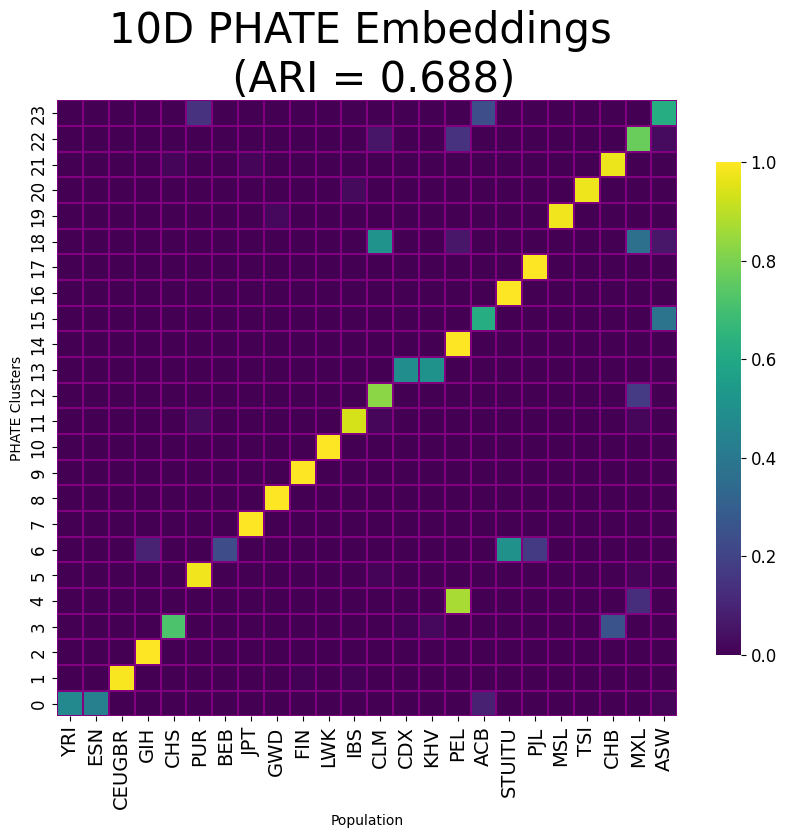

In [29]:
fig, axes = plt.subplots(1,1, figsize=(10, 8))
make_confusion_matrix(clusters_10d, ax=axes, colorbar=True)
_ = axes.set_title(f'10D PHATE Embeddings \n (ARI = {ARI_10d:.3f})', size=30)